In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [2]:
!pip install keras_cv -q

In [3]:
!pip install --upgrade keras

In [4]:
!pip install segmentation_models

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras import ops
import keras_cv
import numpy as np
import segmentation_models as sm
from keras_cv.datasets.pascal_voc.segmentation import load as load_voc
from tensorflow.keras import backend as K

Segmentation Models: using `tf.keras` framework.


In [6]:
train_ds = load_voc(split="sbd_train")
eval_ds = load_voc(split="sbd_eval")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


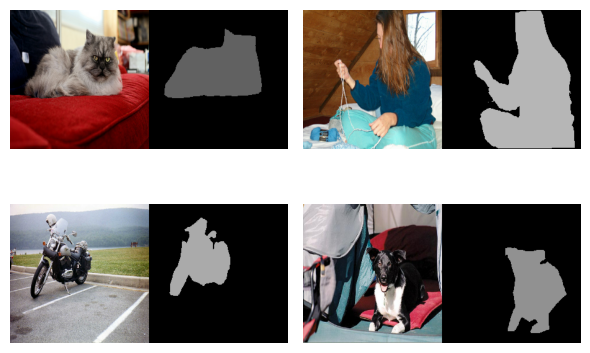

In [7]:
def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=224, width=224))
    outputs = outputs.batch(32, drop_remainder=True)
    return outputs


train_ds = preprocess_tfds_inputs(train_ds)
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [8]:
eval_ds = preprocess_tfds_inputs(eval_ds)

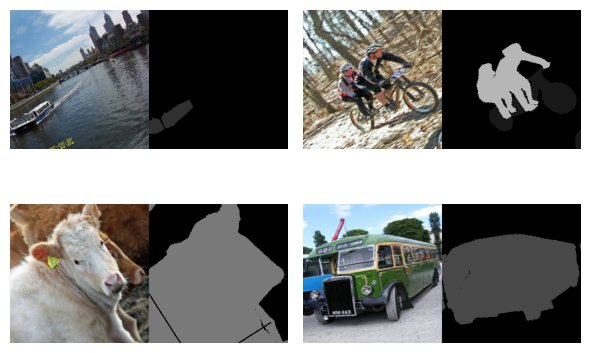

In [9]:
train_ds = train_ds.map(keras_cv.layers.RandomFlip())
train_ds = train_ds.map(keras_cv.layers.RandomRotation(factor=.1,segmentation_classes=21))

batch = train_ds.take(1).get_single_element()

keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
def unet_model(input_size=(224,224, 3)):
    #build the model
    ####################
    #your code goes here
    ####################
    inputs = layers.Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(21, (1, 1), activation='softmax')(c9)  # 21 classes for Pascal VOC

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = unet_model()


In [11]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [12]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [13]:
metrics=['accuracy', jaccard_coef]
#compile the model
####################
#your code goes here
####################
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 28, 28, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,033,045 (118.38 MB)

 Trainable params: 31,033,045 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def dict_to_tuple(x):


    return x["images"], tf.one_hot(
        tf.cast(tf.squeeze(x["segmentation_masks"], axis=-1), "int32"), 21
    )


train_ds = train_ds.map(dict_to_tuple)

eval_ds = eval_ds.map(dict_to_tuple)



In [16]:
# Callback
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_unet_scratch.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]

In [17]:
model.fit(train_ds, validation_data=eval_ds, epochs=10 )

Epoch 1/10
    265/Unknown 828s 2s/step - accuracy: 0.6297 - jaccard_coef: 0.3638 - loss: 0.9873

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


265/265 ━━━━━━━━━━━━━━━━━━━━ 870s 3s/step - accuracy: 0.6297 - jaccard_coef: 0.3637 - loss: 0.9873 - val_accuracy: 0.6226 - val_jaccard_coef: 0.3295 - val_loss: 0.9481
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.6252 - jaccard_coef: 0.3572 - loss: 0.9470 - val_accuracy: 0.5961 - val_jaccard_coef: 0.3597 - val_loss: 0.9385
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 735s 3s/step - accuracy: 0.6078 - jaccard_coef: 0.3763 - loss: 0.9355 - val_accuracy: 0.5720 - val_jaccard_coef: 0.3590 - val_loss: 0.9321
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - accuracy: 0.6018 - jaccard_coef: 0.3865 - loss: 0.9310 - val_accuracy: 0.5597 - val_jaccard_coef: 0.3571 - val_loss: 0.9322
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.5982 - jaccard_coef: 0.3915 - loss: 0.9257 - val_accuracy: 0.5598 - val_jaccard_coef: 0.3530 - val_loss: 0.9216
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.5999 - jaccard_coef: 0.3951 - loss: 0.9192 - val_

In [18]:
activation='softmax'

LR = 0.001
optim = keras.optimizers.Adam(LR)


dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [19]:
BACKBONE1 = 'mobilenetv2'

n_classes=21
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics=metrics)
print(model1.summary())

/usr/local/lib/python3.10/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ Conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 8,014,245 (30.57 MB)

 Non-trainable params: 36,096 (141.00 KB)

None


In [20]:
flag = True
for l in model1.layers:
  if  l.name=='decoder_stage0_upsampling':
    flag = False
  if flag:
    l.trainable = False

In [21]:
model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ Conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 5,790,373 (22.09 MB)

 Non-trainable params: 2,259,968 (8.62 MB)

In [22]:
model1.fit(train_ds, validation_data=eval_ds, epochs=10, batch_size=32 )

Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.5399 - jaccard_coef: 0.2919 - loss: 0.9476 - val_accuracy: 0.5146 - val_jaccard_coef: 0.2572 - val_loss: 0.9410
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.6613 - jaccard_coef: 0.4250 - loss: 0.8907 - val_accuracy: 0.5910 - val_jaccard_coef: 0.3333 - val_loss: 0.8994
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.6402 - jaccard_coef: 0.4303 - loss: 0.8703 - val_accuracy: 0.5612 - val_jaccard_coef: 0.3457 - val_loss: 0.8784
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.6356 - jaccard_coef: 0.4401 - loss: 0.8560 - val_accuracy: 0.6282 - val_jaccard_coef: 0.4326 - val_loss: 0.8583
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.6478 - jaccard_coef: 0.4574 - loss: 0.8412 - val_accuracy: 0.7033 - val_jaccard_coef: 0.5205 - val_loss: 0.8355
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.6625 - jaccard_coef: 0.4750 - loss: 0.

In [23]:
#let all the layers be trained
####################
#your code goes here
####################
for l in model1.layers:
    l.trainable = True

In [24]:
LR = 0.000005
optim = keras.optimizers.Adam(LR)

In [25]:
model1.compile(optim, total_loss, metrics=metrics)

In [26]:
model1.fit(train_ds, validation_data=eval_ds, epochs=5, batch_size=32 )

Epoch 1/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.6522 - jaccard_coef: 0.4659 - loss: 0.8416 - val_accuracy: 0.5897 - val_jaccard_coef: 0.3996 - val_loss: 0.8129
Epoch 2/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.7013 - jaccard_coef: 0.5197 - loss: 0.7628 - val_accuracy: 0.6630 - val_jaccard_coef: 0.4763 - val_loss: 0.7479
Epoch 3/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.7279 - jaccard_coef: 0.5506 - loss: 0.7206 - val_accuracy: 0.7127 - val_jaccard_coef: 0.5328 - val_loss: 0.7016
Epoch 4/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.7430 - jaccard_coef: 0.5693 - loss: 0.6935 - val_accuracy: 0.7411 - val_jaccard_coef: 0.5675 - val_loss: 0.6658
Epoch 5/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.7498 - jaccard_coef: 0.5785 - loss: 0.6853 - val_accuracy: 0.7574 - val_jaccard_coef: 0.5888 - val_loss: 0.6537
